# This is a notebook for examining the output of the bggp_lima_tinygp.py script. 

In [1]:
import arviz as az
import numpy as np
import jax.numpy as jnp
import xarray as xr

import os
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from textwrap import wrap
cm = 1/2.54  # centimeters in inches

from src.helper_functions import unstandardise
from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import build_gp
from src.plotting_functions import pcolormesh_basemapplot
from src.plotting_functions import scatter_basemapplot

2022-09-20 13:34:34.884596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
base_path = '/data/notebooks/jupyterlab-biascorrlab/data/'

In [3]:
#Loading BGGP inference data 
idata_path = f'{base_path}ProcessedData/AP_Daily_Snowfall_Land_Only_Distributed_Observations_100_BGGP_Fit.nc'
idata = az.from_netcdf(idata_path)

In [4]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [96]:
az.summary(idata.posterior[parameters])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_kern_var     1.016  0.006   1.007    1.027      0.000    0.000   
alpha_lengthscale  2.164  1.341   1.223    3.767      0.040    0.028   
alpha_like_var     1.004  0.002   1.000    1.008      0.000    0.000   
alpha_mean         0.751  0.033   0.687    0.811      0.001    0.001   
p_kern_var         0.587  0.024   0.549    0.630      0.001    0.001   
p_lengthscale      0.679  0.050   0.599    0.772      0.001    0.001   
p_like_var         0.505  0.004   0.500    0.513      0.000    0.000   
p_mean             0.554  0.052   0.461    0.652      0.001    0.001   

                   ess_bulk  ess_tail  r_hat  
alpha_kern_var       1384.0    1219.0    NaN  
alpha_lengthscale    1048.0    1530.0    NaN  
alpha_like_var        882.0     859.0    NaN  
alpha_mean           2008.0    1244.0    NaN  
p_kern_var           1498.0    1069.0    NaN  
p_lengthscale        1321.0    1144.0    NaN  
p_like_var           1331.0     949.0    NaN  
p_mean               2010.0     999.0    NaN

## Examining Posterior

/data/conda/bc/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


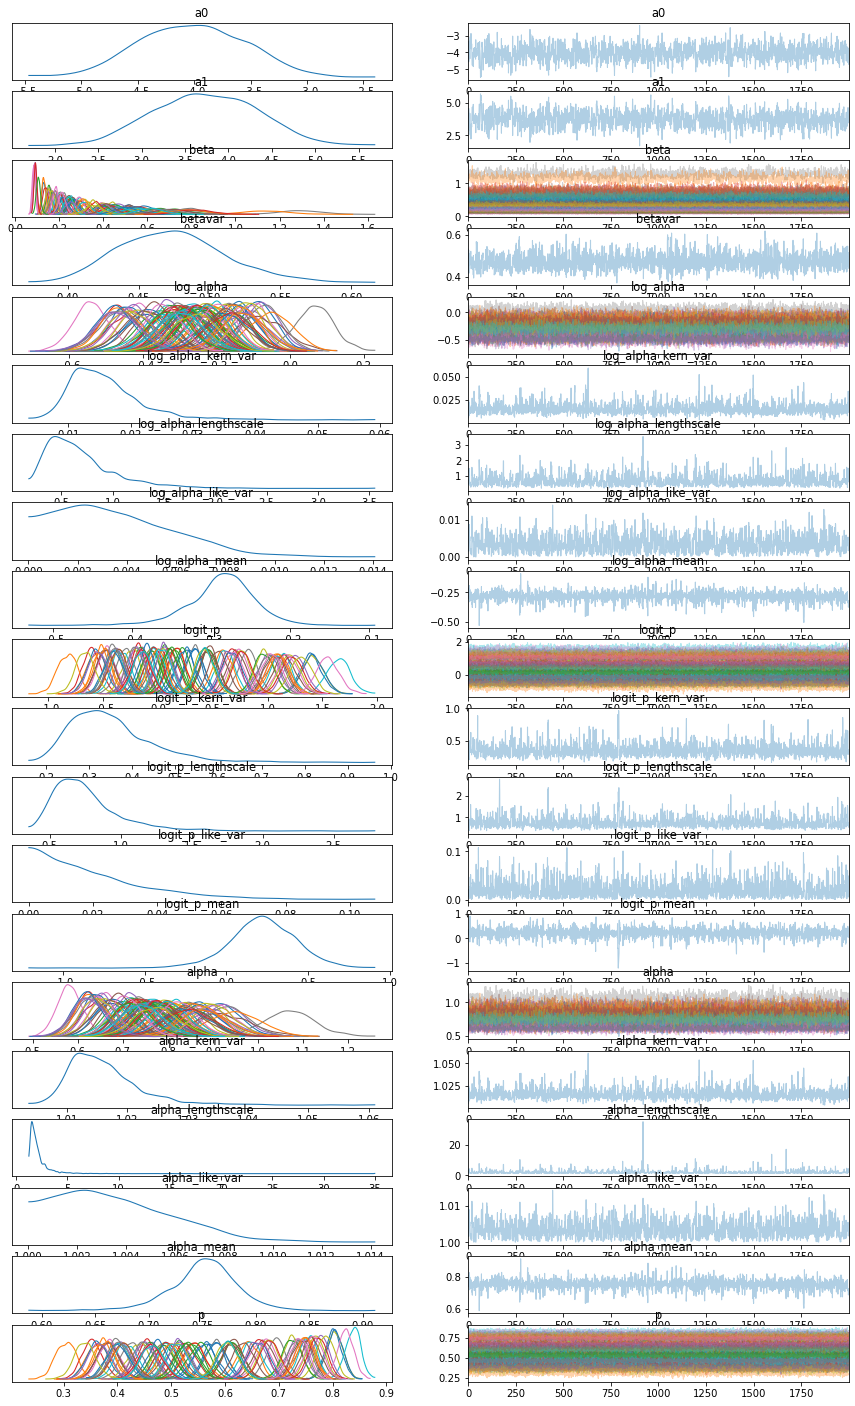

In [71]:
az.plot_trace(idata, compact=True, figsize=(15, 25));

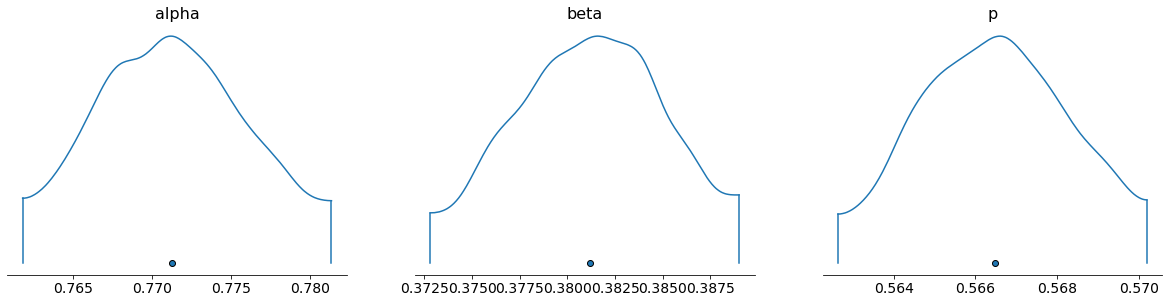

In [72]:
az.plot_density(idata.posterior.mean('sites'),var_names=['alpha','beta','p'])
plt.show()

In [73]:
parameters = ['alpha_kern_var',
 'alpha_lengthscale',
 'alpha_like_var',
 'alpha_mean',
 'p_kern_var',
 'p_lengthscale',
 'p_like_var',
 'p_mean']

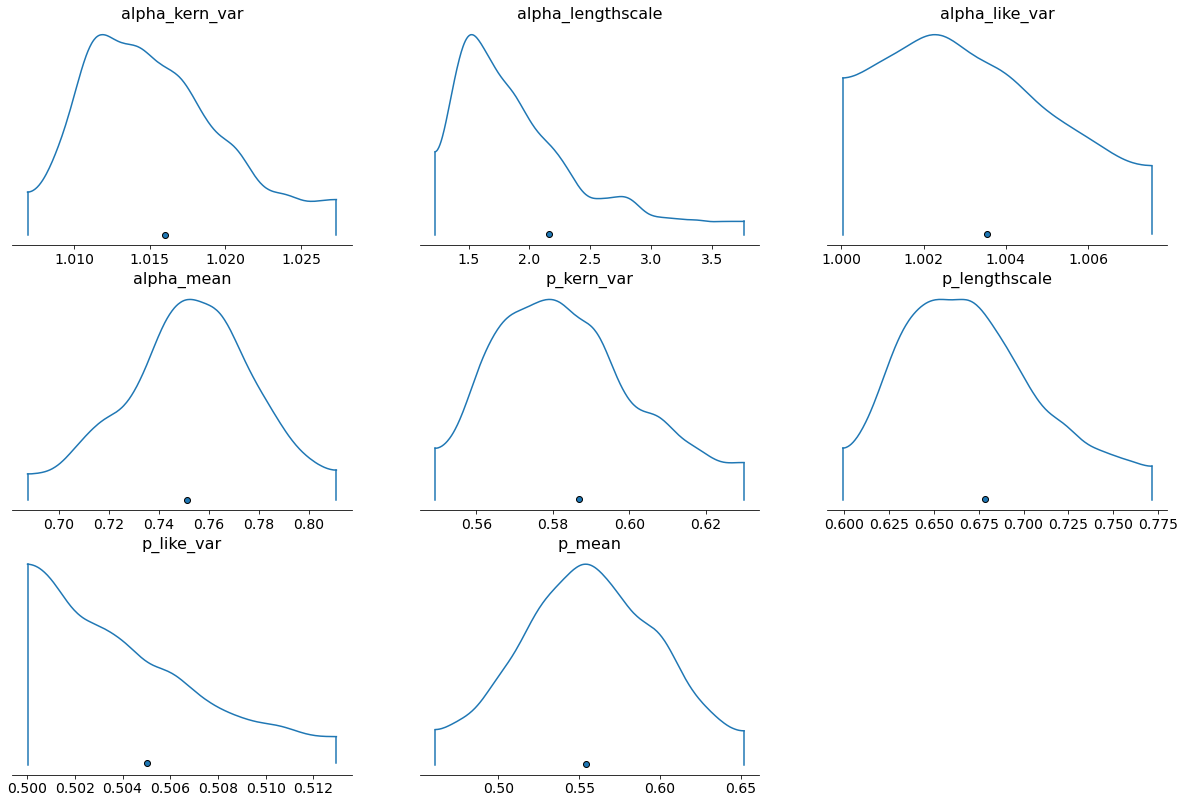

In [74]:
az.plot_density(idata.posterior,var_names=parameters)
plt.show()

/data/conda/bc/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


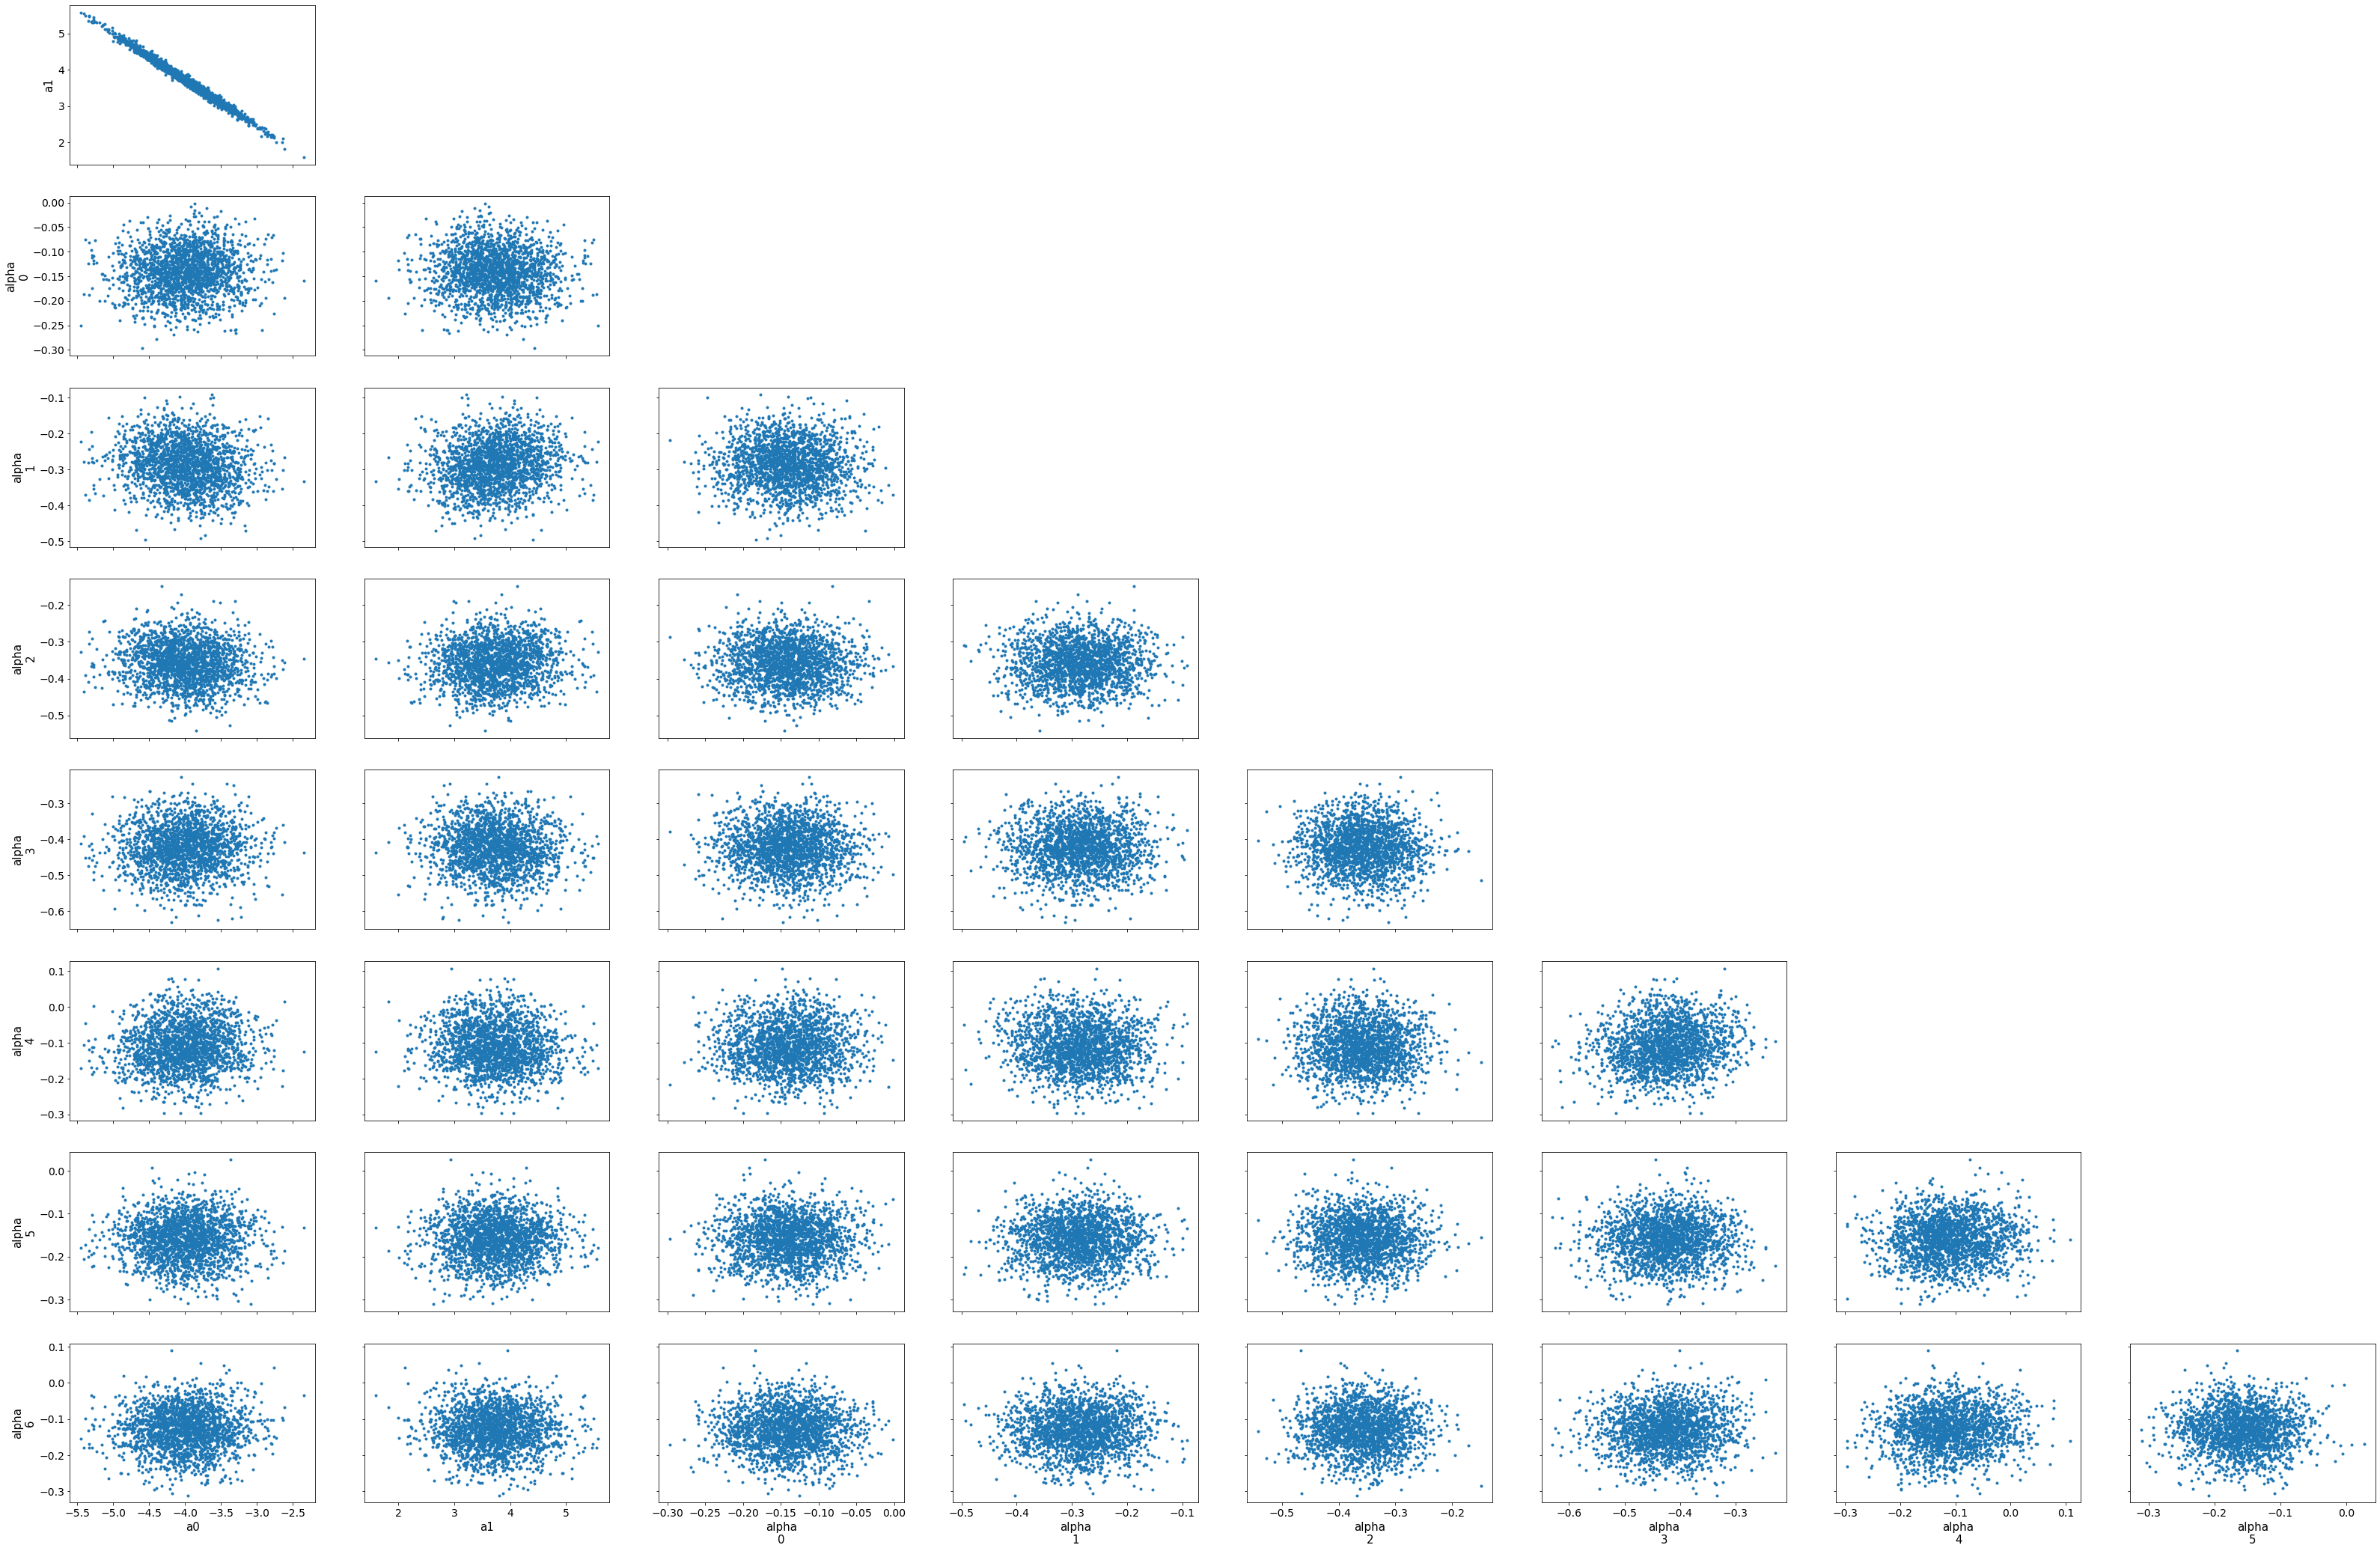

In [20]:
az.plot_pair(bggp_idata)
plt.show()

## Conditioning on New Grid (Posterior Predictive)

In [75]:
#Defining new grid to make predictions over 
'''coordinates are in standardised units equivalent to the grid_lat_standardised and grid_lon_standardised coordinates used to fit the GP in gp_lima_tinygp.py'''
x_new = np.arange(-3,3,0.1)
x_new_grid = np.meshgrid(x_new,x_new)
X_new = np.array(x_new_grid).reshape((2,-1)).T

In [77]:
#Constructing the GP objects from the inference data
alpha_gp = build_gp(idata,'alpha')
p_gp = build_gp(idata,'p')
#Conditioning based on observed data and on new coordinates
expectations = idata.posterior.mean(['chain','draw'])
_, alpha_gpcond = alpha_gp.condition(expectations['alpha'].data, X_new)
_, p_gpcond = alpha_gp.condition(expectations['p'].data, X_new)

In [78]:
#Getting the mean and standard deviation of predictions
alpha_mean,alpha_std = alpha_gpcond.mean,np.sqrt(alpha_gpcond.variance)
p_mean,p_std = p_gpcond.mean,np.sqrt(p_gpcond.variance)

In [79]:
#Placing results into xarray dataset
ds = xr.Dataset(
    data_vars=dict(
        alpha=(["grid_latitude","grid_longitude","metric"], np.dstack([alpha_mean.reshape((len(x_new),-1)),alpha_std.reshape((len(x_new),-1))])),
        p=(["grid_latitude","grid_longitude","metric"], np.dstack([p_mean.reshape((len(x_new),-1)),p_std.reshape((len(x_new),-1))])),
    ),
    coords=dict(
        grid_longitude_standardised=("grid_longitude", x_new),
        grid_latitude_standardised=("grid_latitude", x_new),
        grid_longitude=("grid_longitude", unstandardise(newdata = x_new,refdata = idata.observed_data.grid_longitude.data)),
        grid_latitude=("grid_latitude", unstandardise(newdata = x_new,refdata = idata.observed_data.grid_latitude.data)),
        metric=("metric", ['mean','std'])
    ),
)
#Calculating actual Latitude/Longitude values at new locations and appending to dataset
ds = grid_coords_to_2d_latlon_coords(ds,'/data/notebooks/jupyterlab-biascorrlab/data/ProcessedData/AP_Daily_Snowfall_044.nc')

In [83]:
ds

<xarray.Dataset>
Dimensions:                      (grid_latitude: 60, grid_longitude: 60, metric: 2)
Coordinates:
    grid_longitude_standardised  (grid_longitude) float64 -3.0 -2.9 ... 2.8 2.9
    grid_latitude_standardised   (grid_latitude) float64 -3.0 -2.9 ... 2.8 2.9
  * grid_longitude               (grid_longitude) float64 152.6 152.9 ... 175.1
  * grid_latitude                (grid_latitude) float64 -7.511 -7.219 ... 9.736
  * metric                       (metric) <U4 'mean' 'std'
    latitude                     (grid_longitude, grid_latitude) float64 -61....
    longitude                    (grid_longitude, grid_latitude) float64 -91....
Data variables:
    alpha                        (grid_latitude, grid_longitude, metric) float64 ...
    p                            (grid_latitude, grid_longitude, metric) float64 ...

### Plotting Mean and Standard Deviation of Predictions against Observations on Standardised Grid

In [89]:
ds['p'].sel(metric='mean').mean()

<xarray.DataArray 'p' ()>
array(0.60535071)
Coordinates:
    metric   <U4 'mean'

In [84]:
expectations

<xarray.Dataset>
Dimensions:                      (sites: 100)
Coordinates:
  * sites                        (sites) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
    grid_latitude                (sites) float64 3.52 2.2 -0.44 ... 2.2 3.08
    grid_longitude               (sites) float64 161.5 161.5 ... 162.8 168.1
    latitude                     (sites) float64 -71.09 -71.32 ... -72.63 -77.59
    longitude                    (sites) float64 -64.45 -68.48 ... -67.85 -59.98
    grid_latitude_standardised   (sites) float64 0.7737 0.3221 ... 0.3221 0.6231
    grid_longitude_standardised  (sites) float64 -0.6495 -0.6495 ... 1.081
Data variables: (12/24)
    a0                           float64 -4.018
    a1                           float64 3.741
    beta                         (sites) float64 0.5195 0.5504 ... 0.3599 0.6158
    betavar                      float64 0.4739
    log_alpha                    (sites) float64 -0.1397 -0.2871 ... -0.2974
    log_alpha_kern_var           float64 0.01589
    ...                           ...
    alpha_mean                   float64 0.7514
    p                            (sites) float64 0.8013 0.3639 ... 0.3398 0.4652
    p_kern_var                   float64 0.5868
    p_lengthscale                float64 0.6785
    p_like_var                   float64 0.505
    p_mean                       float64 0.554

Text(0.5, 1.0, 'Prediction Std (Sigma_Alpha)')

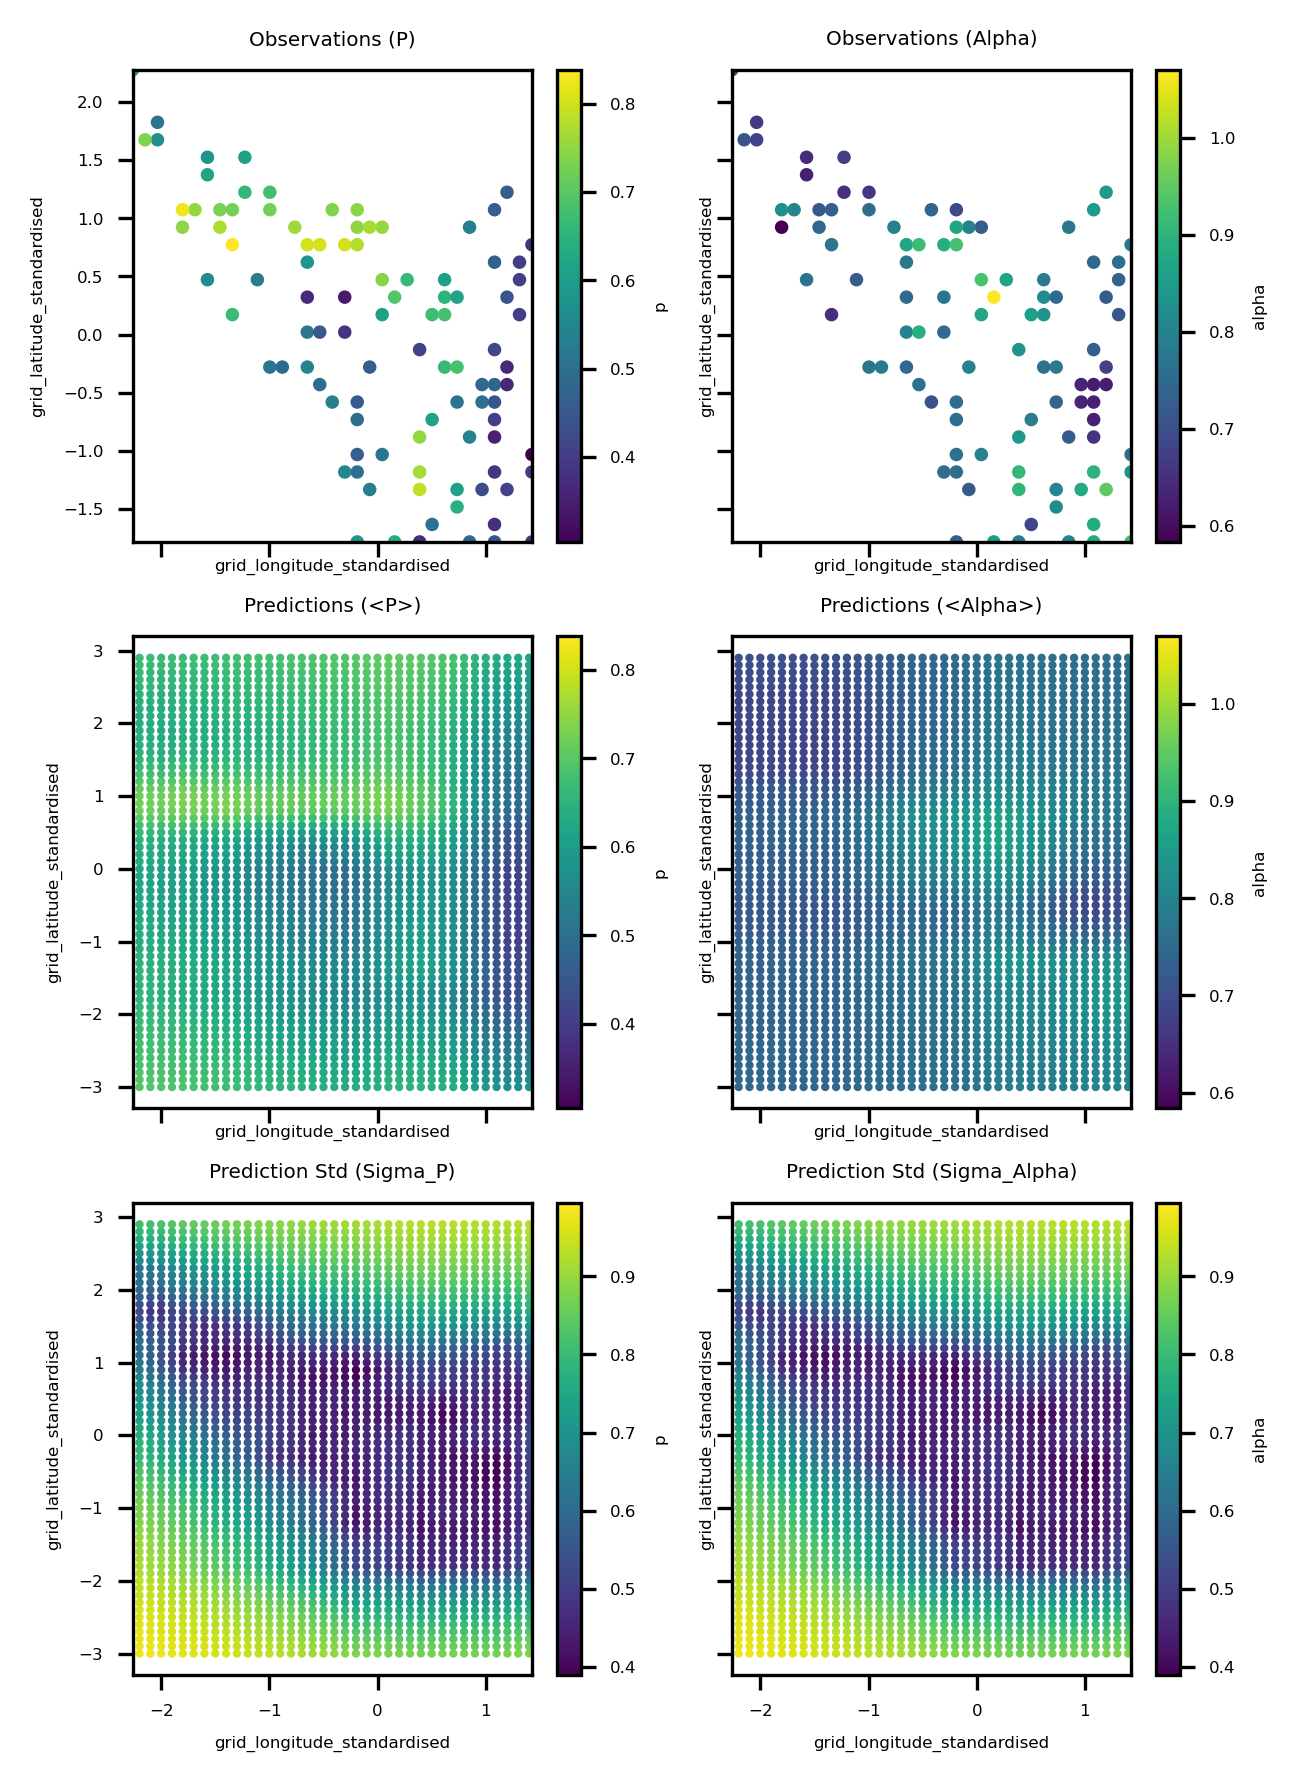

In [80]:
fontsize = 4
plt.rcParams.update({'font.size': fontsize})
min_grid_longitude_standardised,max_grid_longitude_standardised = idata.observed_data.grid_longitude_standardised.min(),idata.observed_data.grid_longitude_standardised.max()
min_grid_latitude_standardised,max_grid_latitude_standardised = idata.observed_data.grid_latitude_standardised.min(),idata.observed_data.grid_latitude_standardised.max()
min_p,max_p = expectations.p.min(),expectations.p.max()
min_alpha,max_alpha = expectations.alpha.min(),expectations.alpha.max()

fig, axs = plt.subplots(3, 2, sharex='col', sharey='row',figsize=(12*cm, 18.0*cm),dpi= 300,linewidth=0.1)

for ax in axs[0]:
    ax.set_xlim([min_grid_longitude_standardised,max_grid_longitude_standardised])
    ax.set_ylim([min_grid_latitude_standardised,max_grid_latitude_standardised])

plt.subplot(3, 2, 1)
expectations.plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='p',s=5,vmin=min_p,vmax=max_p)
plt.title('Observations (P)')
plt.subplot(3, 2, 2)
expectations.plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='alpha',s=5,vmin=min_alpha,vmax=max_alpha)
plt.title('Observations (Alpha)')
plt.subplot(3, 2, 3)
ds.sel(metric='mean').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='p',s=1,vmin=min_p,vmax=max_p)
plt.title('Predictions (<P>)')
plt.subplot(3, 2, 4)
ds.sel(metric='mean').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='alpha',s=1,vmin=min_alpha,vmax=max_alpha)
plt.title('Predictions (<Alpha>)')
plt.subplot(3, 2, 5)
ds.sel(metric='std').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='p',s=1)
plt.title('Prediction Std (Sigma_P)')
plt.subplot(3, 2, 6)
ds.sel(metric='std').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='alpha',s=1)
plt.title('Prediction Std (Sigma_Alpha)')

### Plotting Mean of Predictions against Observations on Latitude-Longitude Grid with Coastlines Marked

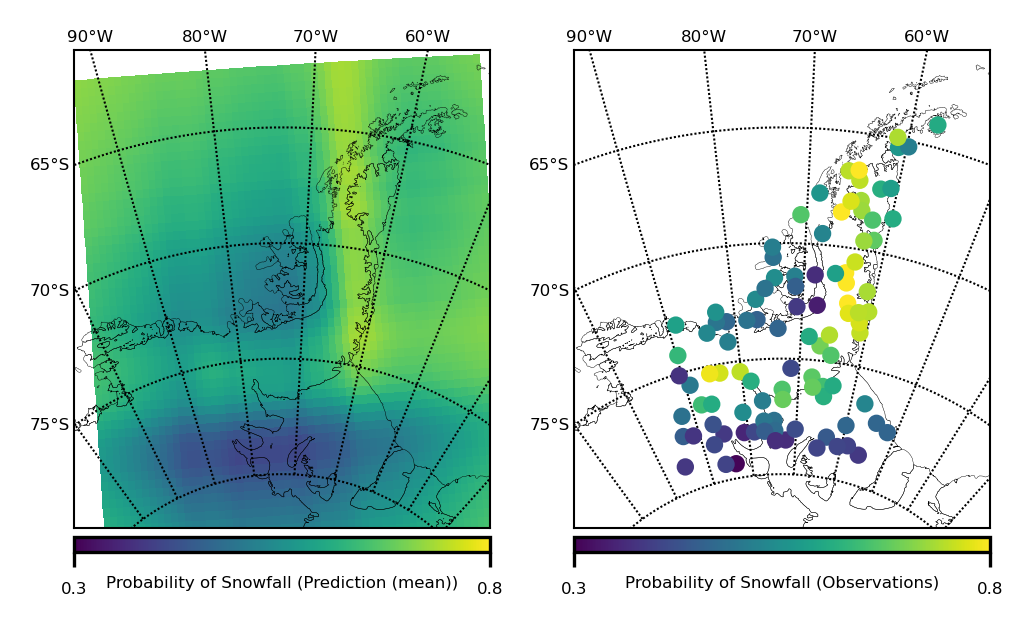

In [81]:
fontsize=4
plt.rcParams.update({'font.size': fontsize})
plots = []
vmin,vmax = 0.3,0.8
variable = 'p'
metric = 'mean'
colorbar_labels = ["\n".join(wrap(f'Probability of Snowfall (Prediction ({metric}))', 100)),"\n".join(wrap('Probability of Snowfall (Observations)', 100))]

antarctica_peninsula_map = Basemap(width=2000000,height=2300000,projection='laea',lat_ts=-30,lat_0=-72,lon_0=-73,resolution='l')
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10*cm, 6.0*cm),dpi= 300,linewidth=0.1)

plt.subplot(1, 2, 1)
plots.append(pcolormesh_basemapplot(ds,variable,metric,antarctica_peninsula_map,vmin=vmin,vmax=vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

plt.subplot(1, 2, 2)
plots.append(scatter_basemapplot(expectations,variable,antarctica_peninsula_map,vmin,vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

for plot,axis,colorbar_label in zip(plots,axs,colorbar_labels):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('bottom', size='3%', pad=0.03)
    cbar = plt.colorbar(plot,cax=cax,orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.ax.set_xticklabels([f'{vmin}', f'{vmax}'],fontsize=fontsize)
    cbar.set_label(colorbar_label,labelpad=-5,fontsize=fontsize)

for axis in axs:
    [x.set_linewidth(0.5) for x in axis.spines.values()]
    
plt.show()

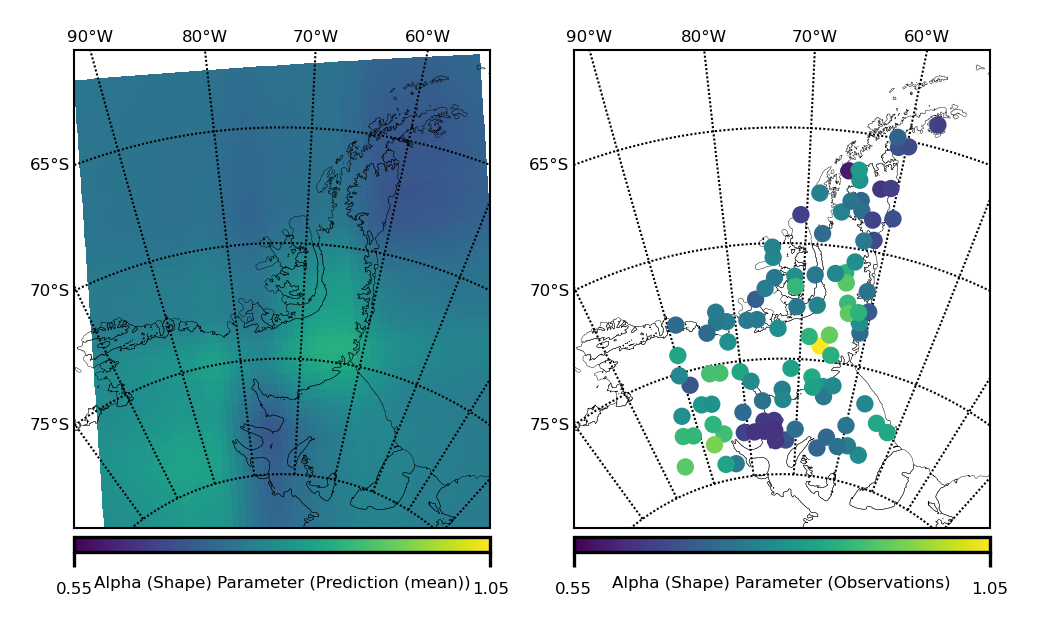

In [82]:
cm = 1/2.54  # centimeters in inches
fontsize=4
plt.rcParams.update({'font.size': fontsize})
plots = []
vmin,vmax = 0.55,1.05
variable = 'alpha'
metric = 'mean'
colorbar_labels = ["\n".join(wrap(f'Alpha (Shape) Parameter (Prediction ({metric}))', 100)),"\n".join(wrap('Alpha (Shape) Parameter (Observations)', 100))]

antarctica_peninsula_map = Basemap(width=2000000,height=2300000,projection='laea',lat_ts=-30,lat_0=-72,lon_0=-73,resolution='l')
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10*cm, 6.0*cm),dpi= 300,linewidth=0.1)

plt.subplot(1, 2, 1)
plots.append(pcolormesh_basemapplot(ds,variable,metric,antarctica_peninsula_map,vmin=vmin,vmax=vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

plt.subplot(1, 2, 2)
plots.append(scatter_basemapplot(expectations,variable,antarctica_peninsula_map,vmin,vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

for plot,axis,colorbar_label in zip(plots,axs,colorbar_labels):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('bottom', size='3%', pad=0.03)
    cbar = plt.colorbar(plot,cax=cax,orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.ax.set_xticklabels([f'{vmin}', f'{vmax}'],fontsize=fontsize)
    cbar.set_label(colorbar_label,labelpad=-5,fontsize=fontsize)

for axis in axs:
    [x.set_linewidth(0.5) for x in axis.spines.values()]
    
plt.show()